In [19]:
## IMPORTS

import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import ee
import time
import os
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import ee
import folium
import geemap

# Connecting to Google Earth Engine

Google Earth Engine offers a vast multi-petabyte catalogue of satellite imagery and geospatial datasets, coupled with powerful planetary-scale analysis capabilities. 

## 1. Convert Farmer Data with Deforestation Alerts to GeoJson and .shp File

Uploading farmer data to Google Earth Engine (GEE) often involves converting it to a GeoJSON format and then to a shapefile because these formats are widely accepted for spatial data processing. GeoJSON is a convenient format for representing geographic features, which can then be easily converted to a shapefile, a common format for storing geographic data that GEE can efficiently handle for large-scale geospatial analyses. This conversion ensures compatibility and facilitates the integration of spatial data into GEE's environment for further analysis and visualization.

The geojson file and shapefiles generated can be observed at [farmer_data_output_shapefile](farmer_data_output_shapefile).

In [24]:
# Read the CSV file
df = pd.read_csv('/Users/amita/Desktop/Phlo Systems/GitHub/farmer_data_deforestation_alerts_summary.csv')

# Function to convert the string representation of polygons into shapely Polygon objects
def parse_polygon(polygon_str):
    # Convert the string to a list of lists
    coordinates = eval(polygon_str)
    return Polygon(coordinates)

# Apply the function to the 'Location' column to create a new 'geometry' column
df['geometry'] = df['Location'].apply(parse_polygon)

# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Save the GeoDataFrame to a GeoJSON file
gdf.to_file('output.geojson', driver='GeoJSON')


In [4]:
# Converting to .shp file to upload to Google Earth Engine

# Define paths
geojson_path = 'output.geojson'
shapefile_path = 'output_shapefile'
zipfile_path = 'output_shapefile.zip'

# Read the GeoJSON file
gdf = gpd.read_file(geojson_path)

# Save as a shapefile
gdf.to_file(shapefile_path, driver='ESRI Shapefile')

# Function to zip shapefile components
def zip_shapefile(shapefile_path, zipfile_path):
    with zipfile.ZipFile(zipfile_path, 'w') as zipf:
        for root, dirs, files in os.walk(shapefile_path):
            for file in files:
                if file.endswith(('.shp', '.shx', '.dbf', '.prj')):
                    zipf.write(os.path.join(root, file),
                               os.path.relpath(os.path.join(root, file),
                                               os.path.join(shapefile_path, '..')))

# Zip the shapefile components
zip_shapefile(shapefile_path, zipfile_path)

print(f'Shapefile zipped to {zipfile_path}')


Shapefile zipped to output_shapefile.zip


/var/folders/p6/cx8dr0q13gjfzl_xg2m5_56h0000gn/T/ipykernel_16368/1004586941.py:14: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(shapefile_path, driver='ESRI Shapefile')


## 2. Connect and Authenticate to Google Earth Engine

The code snippet below connects to Google Earth Engine (GEE) by initializing the API with a service account's credentials. Setting the GOOGLE_APPLICATION_CREDENTIALS environment variable to the path of the service account key file allows secure authentication. The ee.Initialize function is then used to establish a connection to GEE, enabling the use of its powerful geospatial analysis tools and datasets for subsequent data processing tasks.

In [2]:
import ee
import os

# Load the environment variable
service_account_key_path = os.getenv('GOOGLE_APPLICATION_CREDENTIALS')

# Initialize Earth Engine with the project ID
try:
    ee.Initialize(project='composite-rune-426012-a1')
    print("Google Earth Engine Initialized successfully.")
except ee.EEException as e:
    print("Initialization error:", e)
    # If initialization fails, re-authenticate (typically not needed for service account)
    ee.Authenticate()
    ee.Initialize()



Google Earth Engine Initialized successfully.


Three different alert datasets: RADD (Radar Alerts for Detecting Deforestation), GLAD Landsat alerts, and GLAD Sentinel-2 alerts are accessed. Which then prints the band names of each dataset to verify the available data layers, which are used for monitoring deforestation and other environmental changes.

In [3]:
# Access the alert datasets
RADD_Original = ee.ImageCollection('projects/radar-wur/raddalert/v1').filterMetadata('layer', 'contains', 'alert').mosaic()
GLAD_L_Original = (ee.ImageCollection('projects/glad/alert/2021final').select(['conf21', 'alertDate21']).mosaic()
                   .addBands(ee.ImageCollection('projects/glad/alert/2022final').select(['conf22', 'alertDate22']).mosaic())
                   .addBands(ee.ImageCollection('projects/glad/alert/UpdResult').select(['conf23', 'alertDate23', 'conf24', 'alertDate24']).mosaic()))
GLAD_S2_Original = ee.Image('projects/glad/S2alert/alert').rename('Alert').addBands(ee.Image('projects/glad/S2alert/alertDate').rename('Date'))

# Print band names
print('RADD_Original bands:', RADD_Original.bandNames().getInfo())
print('GLAD_L_Original bands:', GLAD_L_Original.bandNames().getInfo())
print('GLAD_S2_Original bands:', GLAD_S2_Original.bandNames().getInfo())


RADD_Original bands: ['Alert', 'Date']
GLAD_L_Original bands: ['conf21', 'alertDate21', 'conf22', 'alertDate22', 'conf23', 'alertDate23', 'conf24', 'alertDate24']
GLAD_S2_Original bands: ['Alert', 'Date']


## 3. Upload the .shp Files to GEE

The .shp files that contain the farmer data and protected areas are uploaded to the GEE platform. Once the shapefile is uploaded to Google Earth Engine (GEE), the powerful cloud-based geospatial processing capabilities can be leveraged to analyze and visualize the data using JavaScript in the GEE Code Editor.

The imported assets are viewed as below:

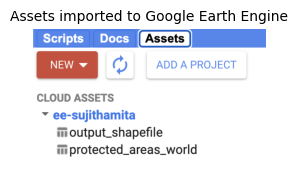

In [15]:
# Load the image
img = mpimg.imread('Images/Screenshot 2024-07-27 at 12.32.02 PM.png')

# Display the image with a larger size and a caption
plt.figure(figsize=(3, 2)) 
plt.imshow(img)
plt.title('Assets imported to Google Earth Engine', fontsize=10)  # Add a caption
plt.axis('off')  # Turn off axis
plt.show()

## 4. Creating Integrated Alerts in GEE 

The JavaScript code for Google Earth Engine (GEE) performs several key tasks to visualize integrated forest disturbance alerts. It begins by importing shapefile and provided dataset assets and defining their visualization parameters. It then accesses and styles three different forest alert datasets: RADD, GLAD-Landsat, and GLAD-Sentinel-2, displaying them on the map along with their respective forest baseline layers. The script integrates these alerts using two rulesets to assign confidence levels to detected disturbances, considering both pixel-based integration and spatial neighborhood buffers. Finally, it adds these integrated alerts to the map with visual parameters and includes legends for the alert confidence levels and dates, aiding in the interpretation of deforestation alerts overlaid on satellite imagery.

The full javascript for vieweing farmer data with integrated alerts can be observed at [GEE_Integrated_Alerts.js](GEE_Integrated_Alerts.js).

## 5. Display the GEE map in Python


After creating the desired visualizations in GEE using JavaScript, these visualizations can be seamlessly integrated into Python for further analysis and display. This integration is achieved using libraries like folium, which are designed to create interactive maps. By exporting the processed data and visualization parameters from GEE to a format compatible with Python, folium can be used to pull in these visuals and display them in a Jupyter Notebook or other Python environment. Folium allows for embedding interactive maps directly in Python, leveraging the combined power of GEE for data processing and Python for visualization and additional analysis. This approach provides a comprehensive workflow for geospatial data analysis, from cloud-based processing in GEE to rich, interactive map displays in Python.

In [18]:
# Initialize Earth Engine
try:
    ee.Initialize(project='composite-rune-426012-a1')
    print("Google Earth Engine Initialized successfully.")
except ee.EEException as e:
    print("Initialization error:", e)
    ee.Authenticate()
    ee.Initialize()

# Define a method for adding Earth Engine layers to folium
def add_ee_layer(self, ee_object, vis_params, name):
    try:
        if isinstance(ee_object, ee.image.Image):
            map_id_dict = ee.Image(ee_object).getMapId(vis_params)
        elif isinstance(ee_object, ee.imagecollection.ImageCollection):
            map_id_dict = ee.Image(ee_object.mosaic()).getMapId(vis_params)
        elif isinstance(ee_object, ee.featurecollection.FeatureCollection):
            map_id_dict = ee.Image().paint(ee_object, 0, 2).getMapId(vis_params)
        else:
            raise AttributeError("The provided ee_object must be an instance of ee.Image, ee.ImageCollection or ee.FeatureCollection")
        
        folium.TileLayer(
            tiles=map_id_dict['tile_fetcher'].url_format,
            attr='Google Earth Engine',
            name=name,
            overlay=True,
            control=True
        ).add_to(self)
    except Exception as e:
        print("Could not add the layer to the map: ", e)

# Add the method to the folium Map class
folium.Map.add_ee_layer = add_ee_layer

# Create a folium map centered on Ghana
Map = folium.Map(location=[7.9465, -1.0232], zoom_start=6)

# Define the paths to your assets
shapefile_asset_path = 'projects/ee-sujithamita/assets/output_shapefile'
provided_dataset_path = 'projects/ee-sujithamita/assets/protected_areas_world'

# Import the shapefile
shapefile_asset = ee.FeatureCollection(shapefile_asset_path)

# Import the provided dataset
provided_dataset = ee.FeatureCollection(provided_dataset_path)

# Define visualization parameters for the shapefile
shapefile_vis_params = {
    'color': 'blue'
}

# Define visualization parameters for the provided dataset
provided_dataset_vis_params = {
    'color': 'white'
}

# Create styled layers for the shapefile and provided dataset
shapefile_styled = shapefile_asset.style(**shapefile_vis_params)
provided_dataset_styled = provided_dataset.style(**provided_dataset_vis_params)

# Add the layers to the folium map
Map.add_ee_layer(shapefile_styled, {}, 'Shapefile Layer')
Map.add_ee_layer(provided_dataset_styled, {}, 'Protected Areas Layer')

# Define visualization parameters for the alerts
alert_vis_params = {
    'bands': ['Alert'],  # Specify the single band to visualize
    'min': 2,
    'max': 4,
    'palette': ['4BA5FF', 'FF0000', '600000']
}

# Access the alert datasets
RADD_Original = ee.ImageCollection('projects/radar-wur/raddalert/v1').filterMetadata('layer', 'contains', 'alert').mosaic()
GLAD_L_Original = (ee.ImageCollection('projects/glad/alert/2021final').select(['conf21', 'alertDate21']).mosaic()
                   .addBands(ee.ImageCollection('projects/glad/alert/2022final').select(['conf22', 'alertDate22']).mosaic())
                   .addBands(ee.ImageCollection('projects/glad/alert/UpdResult').select(['conf23', 'alertDate23', 'conf24', 'alertDate24']).mosaic()))
GLAD_S2_Original = ee.Image('projects/glad/S2alert/alert').rename('Alert').addBands(ee.Image('projects/glad/S2alert/alertDate').rename('Date'))

# Custom functions for converting alerts
def convertRADD(image):
    return image.select(['Alert'])  # Ensure only the 'Alert' band is selected

def convertGLAD_L(image):
    return image.select(['conf21']).rename(['Alert'])  # Ensure only the 'Alert' band is selected

def convertGLAD_S2(image):
    return image.select(['Alert'])  # Ensure only the 'Alert' band is selected

# Reformat the datasets to include common alert levels and standardize the date format
RADD = convertRADD(RADD_Original)
GLAD_L = convertGLAD_L(GLAD_L_Original)
GLAD_S2 = convertGLAD_S2(GLAD_S2_Original)

# Add the alert layers to the folium map
Map.add_ee_layer(RADD, alert_vis_params, 'RADD')
Map.add_ee_layer(GLAD_L, alert_vis_params, 'GLAD_L')
Map.add_ee_layer(GLAD_S2, alert_vis_params, 'GLAD_S2')

# Integration functions based on the initial JavaScript code
def integrate_alerts(alerts, ruleset):
    return alerts[0].max(alerts[1]).max(alerts[2])

# Pixel-based integration (without considering the spatial neighborhood)
ruleset1 = integrate_alerts([RADD, GLAD_L, GLAD_S2], 'r1')
ruleset2 = integrate_alerts([RADD, GLAD_L, GLAD_S2], 'r2')

# Add the integrated alert layers to the folium map
Map.add_ee_layer(ruleset1, alert_vis_params, 'Integrated alert (Ruleset-1)')
Map.add_ee_layer(ruleset2, alert_vis_params, 'Integrated alert (Ruleset-2)')

# Add layer control to the map
Map.add_child(folium.LayerControl())

# Save the map to HTML
Map.save("map_with_layers.html")

# Display the map
Map


Google Earth Engine Initialized successfully.


Displaying the map with Sentinel-2 satellite imagery

In [20]:
# Initialize Earth Engine
try:
    ee.Initialize(project='composite-rune-426012-a1')
    print("Google Earth Engine Initialized successfully.")
except ee.EEException as e:
    print("Initialization error:", e)
    ee.Authenticate()
    ee.Initialize()

# Define a method for adding Earth Engine layers to folium
def add_ee_layer(self, ee_object, vis_params, name):
    try:
        if isinstance(ee_object, ee.image.Image):
            map_id_dict = ee.Image(ee_object).getMapId(vis_params)
        elif isinstance(ee_object, ee.imagecollection.ImageCollection):
            map_id_dict = ee.Image(ee_object.mosaic()).getMapId(vis_params)
        elif isinstance(ee_object, ee.featurecollection.FeatureCollection):
            map_id_dict = ee.Image().paint(ee_object, 0, 2).getMapId(vis_params)
        else:
            raise AttributeError("The provided ee_object must be an instance of ee.Image, ee.ImageCollection or ee.FeatureCollection")
        
        folium.TileLayer(
            tiles=map_id_dict['tile_fetcher'].url_format,
            attr='Google Earth Engine',
            name=name,
            overlay=True,
            control=True
        ).add_to(self)
    except Exception as e:
        print("Could not add the layer to the map: ", e)

# Add the method to the folium Map class
folium.Map.add_ee_layer = add_ee_layer

# Create a folium map centered on Ghana
Map = folium.Map(location=[7.9465, -1.0232], zoom_start=6)

# Define the paths to your assets
shapefile_asset_path = 'projects/ee-sujithamita/assets/output_shapefile'
provided_dataset_path = 'projects/ee-sujithamita/assets/protected_areas_world'

# Import the shapefile
shapefile_asset = ee.FeatureCollection(shapefile_asset_path)

# Import the provided dataset
provided_dataset = ee.FeatureCollection(provided_dataset_path)

# Define visualization parameters for the shapefile
shapefile_vis_params = {
    'color': 'blue'
}

# Define visualization parameters for the provided dataset
provided_dataset_vis_params = {
    'color': 'white'
}

# Create styled layers for the shapefile and provided dataset
shapefile_styled = shapefile_asset.style(**shapefile_vis_params)
provided_dataset_styled = provided_dataset.style(**provided_dataset_vis_params)

# Add the layers to the folium map
Map.add_ee_layer(shapefile_styled, {}, 'Shapefile Layer')
Map.add_ee_layer(provided_dataset_styled, {}, 'Protected Areas Layer')

# Define visualization parameters for the alerts
alert_vis_params = {
    'bands': ['Alert'],  # Specify the single band to visualize
    'min': 2,
    'max': 4,
    'palette': ['4BA5FF', 'FF0000', '600000']
}

# Access the alert datasets
RADD_Original = ee.ImageCollection('projects/radar-wur/raddalert/v1').filterMetadata('layer', 'contains', 'alert').mosaic()
GLAD_L_Original = (ee.ImageCollection('projects/glad/alert/2021final').select(['conf21', 'alertDate21']).mosaic()
                   .addBands(ee.ImageCollection('projects/glad/alert/2022final').select(['conf22', 'alertDate22']).mosaic())
                   .addBands(ee.ImageCollection('projects/glad/alert/UpdResult').select(['conf23', 'alertDate23', 'conf24', 'alertDate24']).mosaic()))
GLAD_S2_Original = ee.Image('projects/glad/S2alert/alert').rename('Alert').addBands(ee.Image('projects/glad/S2alert/alertDate').rename('Date'))

# Custom functions for converting alerts
def convertRADD(image):
    return image.select(['Alert'])  # Ensure only the 'Alert' band is selected

def convertGLAD_L(image):
    return image.select(['conf21']).rename(['Alert'])  # Ensure only the 'Alert' band is selected

def convertGLAD_S2(image):
    return image.select(['Alert'])  # Ensure only the 'Alert' band is selected

# Reformat the datasets to include common alert levels and standardize the date format
RADD = convertRADD(RADD_Original)
GLAD_L = convertGLAD_L(GLAD_L_Original)
GLAD_S2 = convertGLAD_S2(GLAD_S2_Original)

# Add the alert layers to the folium map
Map.add_ee_layer(RADD, alert_vis_params, 'RADD')
Map.add_ee_layer(GLAD_L, alert_vis_params, 'GLAD_L')
Map.add_ee_layer(GLAD_S2, alert_vis_params, 'GLAD_S2')

# Integration functions based on the initial JavaScript code
def integrate_alerts(alerts, ruleset):
    return alerts[0].max(alerts[1]).max(alerts[2])

# Pixel-based integration (without considering the spatial neighborhood)
ruleset1 = integrate_alerts([RADD, GLAD_L, GLAD_S2], 'r1')
ruleset2 = integrate_alerts([RADD, GLAD_L, GLAD_S2], 'r2')

# Add the integrated alert layers to the folium map
Map.add_ee_layer(ruleset1, alert_vis_params, 'Integrated alert (Ruleset-1)')
Map.add_ee_layer(ruleset2, alert_vis_params, 'Integrated alert (Ruleset-2)')

# Add satellite imagery
# Define the area of interest
aoi = ee.Geometry.Polygon([
    [[-3.5, 4.5], [-3.5, 11.5], [2.5, 11.5], [2.5, 4.5], [-3.5, 4.5]]
])

# Access Sentinel-2 Image Collection
sentinel2 = ee.ImageCollection('COPERNICUS/S2') \
    .filterBounds(aoi) \
    .filterDate('2023-01-01', '2023-12-31') \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
    .median()

# Define visualization parameters for Sentinel-2
sentinel2_vis_params = {
    'bands': ['B4', 'B3', 'B2'],  # RGB bands
    'min': 0,
    'max': 3000,
    'gamma': 1.4
}

# Add Sentinel-2 imagery to the map
Map.add_ee_layer(sentinel2, sentinel2_vis_params, 'Sentinel-2 Imagery')

# Add layer control to the map
Map.add_child(folium.LayerControl())

# Save the map to HTML
Map.save("map_with_layers.html")

# Display the map
Map

Google Earth Engine Initialized successfully.


## 6. Building the Visualisation Dashboard

A data visualisation dashboard that visualises the farmer datawhich contains the deforestaation alerts from GFW is visualised along with the alert data pulled in from Google Earth Engine. Creation of a visualisation dashboard enables the clients of Phlo Systems to efficiently analyse the deforestation data for EUDR compliance.

The dashboard script on [dashboard_dash.py](dashboard_dash.py) sets up a data visualization dashboard using Dash, a web application framework for Python. The dashboard is designed to display various metrics related to deforestation alerts based on farmer data. It starts by loading and processing the data from a CSV file, converting the 'Production Date' column to a datetime format for accurate time series analysis. The layout of the dashboard includes four graphs: total alerts over time, total alerts by product type, alerts by deforestation driver, and overall confidence by product type. Additionally, it embeds an interactive map created with Folium. The dashboard uses callbacks to dynamically update the graphs based on the data, providing an interactive and informative interface for monitoring deforestation alerts. When run, the app will serve a web page that allows users to explore and analyze the deforestation data visually.

Snippets of the visualisations used can be observed below:

In [67]:
import plotly.express as px

# Aggregate data by Product Type
product_alerts = data.groupby('Product Type')['Total Alerts'].sum().reset_index()

# Create a bar chart for total alerts by product type
fig1 = px.bar(product_alerts, x='Product Type', y='Total Alerts', title='Total Deforestation Alerts by Product Type')

# Display the bar chart
fig1.show()


In [68]:
data['Production Date'] = pd.to_datetime(data['Production Date'], format='%d/%m/%y')

# Aggregate data by Production Date
date_alerts = data.groupby('Production Date')['Total Alerts'].sum().reset_index()

# Create a line chart for total alerts over time
fig2 = px.line(date_alerts, x='Production Date', y='Total Alerts', title='Total Deforestation Alerts Over Time')

# Display the line chart
fig2.show()


In [69]:
# Aggregate data by Deforestation Driver
driver_alerts = data.groupby('Deforestation Driver')['Total Alerts'].sum().reset_index()

# Create a pie chart for alerts by deforestation driver
fig3 = px.pie(driver_alerts, names='Deforestation Driver', values='Total Alerts', title='Deforestation Alerts by Driver')

# Display the pie chart
fig3.show()


In [70]:
# Aggregate data by Product Type and calculate average overall confidence percentage
confidence_data = data.groupby('Product Type')['Overall Confidence %'].mean().reset_index()

# Create a bar chart for overall confidence percentage by product type
fig4 = px.bar(confidence_data, x='Product Type', y='Overall Confidence %', title='Overall Confidence Percentage by Product Type')

# Display the bar chart
fig4.show()
